In [1]:
# !pip uninstall snowflake -y

In [6]:
# general
import boto3
import datetime as dt
import json
import numpy as np
import pandas as pd
import snowflake.connector
from sklearn import preprocessing

In [7]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

In [8]:
pd.options.display.float_format = '{:,.2f}'.format

In [9]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
## WRITE OR READ FROM S3 ####
import boto3
import io

s3 = boto3.resource('s3')
output_bucket = "hbo-outbound-datascience-content-dev"
input_bucket = "hbo-ingest-datascience-content-dev"
bucket = s3.Bucket(input_bucket)

def write_to_sf(df, file_name):
    csv_buffer = io.StringIO()
    df.to_csv(csv_buffer, index = False)
    content = csv_buffer.getvalue()
    filename = 'title_hours_viewed_retention/{}.csv'.format(file_name)
    client = boto3.client('s3')
    client.put_object(Bucket=output_bucket, Key=filename, Body=content)
    
def write_to_input(df, file_name):
    csv_buffer = io.StringIO()
    df.to_csv(csv_buffer, index = False)
    content = csv_buffer.getvalue()
    filename = 'title_hours_viewed_retention/{}.csv'.format(file_name)
    client = boto3.client('s3')
    client.put_object(Bucket=input_bucket, Key=filename, Body=content)
    
def read_from_s3(filename, input_bucket = input_bucket):
    for obj in bucket.objects.filter(Prefix=filename): #churn_metric_0811
            key = obj.key 
            body = obj.get()['Body']
            print('Reading {0} features'.format(key))
            df = pd.read_csv(body, na_values = [r'\\\\N'])
    return df

# 0. Read Training Data

In [23]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy.optimize import curve_fit

In [24]:
training_data = pd.read_csv('latam_training_data.csv')

In [25]:
training_data.head()

,Unnamed: 0,title_series,legacy_series_id,ckg_series_id,imdb_id,program_type,primary_genre,first_release_date,theatrical_date,area_gross,budget,observed_medal,latam_home_medal,day_on_max,cumulative_viewing_subscribers,cumulative_first_views,percent_cumulative_viewing_subscribers,percent_cumulative_first_views,days_from_theatrical,genre_Action,genre_Comedy,genre_Drama,genre_Fantasy & Sci-Fi,genre_Horror,genre_Kids & Family,genre_Music,genre_Not A Genre,medal_Bronze,medal_Gold,medal_Platinum,medal_Silver,medal_number,log_cumulative_first_views,log_cumulative_viewing_subs
0,2,Ambulance,GYyRIgQNLUhu1wwEAAAAF,GYyRIgQNLUhu1wwEAAAAF,tt4998632,Acquired,Action,2022-11-24,2022-03-17,"1,218,886.00","40,000,000.00",Silver,Silver,90.00,"1,107,532.00","7,058.00",8.84,0.20,252,1,0,0,0,0,0,0,0,0,0,0,1,2,12.79,20.08
1,3,Armageddon Time,GZK1nDg0nFaXCwgEAABAp,1e047963-2433-4a1a-8095-830022a0ce57,tt10343028,Acquired,Drama,2023-08-10,2023-03-16,"3,967.00","15,000,000.00",Bronze,Bronze,90.00,"34,968.00",226.00,0.30,0.01,147,0,0,1,0,0,0,0,0,1,0,0,0,3,7.82,15.09
2,7,Belfast,GYpn_UA8YyZ3DZgEAAAAW,0b926c5b-b8e4-401c-ba69-783ce07ad098,tt12789558,Acquired,Drama,2022-10-27,2022-03-10,"109,066.00","11,000,000.00",Bronze,Bronze,90.00,"137,179.00",522.00,1.13,0.02,231,0,0,1,0,0,0,0,0,1,0,0,0,3,9.03,17.07
3,8,Black Adam,GYzcHIw5407mRsAEAAAA4,0c730836-253b-4338-a3d1-a6a44a3384e0,tt6443346,Acquired,Action,2022-12-16,2022-10-20,"9,282,592.00","195,000,000.00",Platinum,Platinum,90.00,"5,705,318.00","208,837.00",44.64,5.42,57,1,0,0,0,0,0,0,0,0,0,1,0,0,17.67,22.44
4,15,Cry Macho,GYSbJuAuzchDCwgEAAAAC,b0598032-1cfd-4605-af5b-52ee492ce717,tt1924245,Acquired,Drama,2021-10-21,2021-10-21,"102,285.00","33,000,000.00",Silver,Silver,90.00,"672,638.00","8,395.00",7.85,0.30,0,0,0,1,0,0,0,0,0,0,0,0,1,2,13.04,19.36


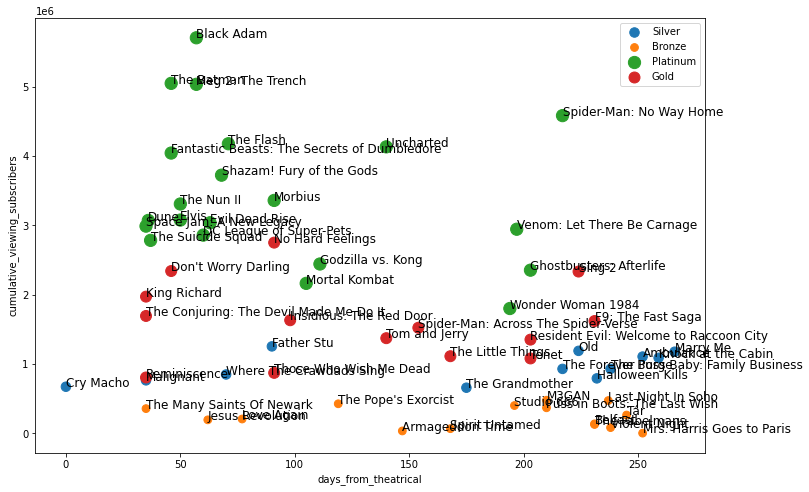

In [26]:
fig, ax = plt.subplots(figsize=(12, 8))
plot_df = training_data
for i in training_data['latam_home_medal'].unique():
    plot_df = training_data[training_data['latam_home_medal'] == i]
    plt.scatter(plot_df['days_from_theatrical'], plot_df['cumulative_viewing_subscribers'], label=i, s = (5-plot_df['medal_number'])*30)

for i in training_data['ckg_series_id'].unique():
    plot_df = training_data[training_data['ckg_series_id'] == i]
    ax.text(plot_df['days_from_theatrical'].values[0], 
            plot_df['cumulative_viewing_subscribers'].values[0], 
            plot_df['title_series'].values[0], size=12)

ax.set_xlabel('days_from_theatrical')
ax.set_ylabel('cumulative_viewing_subscribers')
ax.legend()

plt.show()

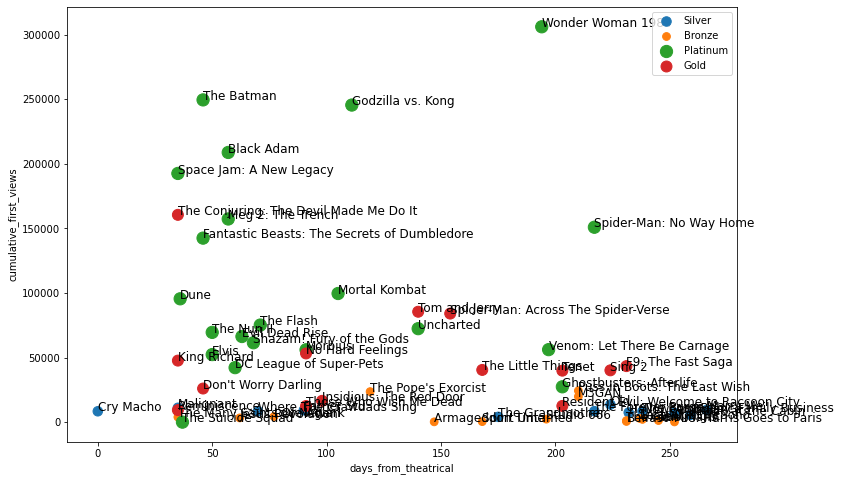

In [27]:
fig, ax = plt.subplots(figsize=(12, 8))
plot_df = training_data
for i in training_data['latam_home_medal'].unique():
    plot_df = training_data[training_data['latam_home_medal'] == i]
    plt.scatter(plot_df['days_from_theatrical'], plot_df['cumulative_first_views'], label=i, s = (5-plot_df['medal_number'])*30)

for i in training_data['ckg_series_id'].unique():
    plot_df = training_data[training_data['ckg_series_id'] == i]
    ax.text(plot_df['days_from_theatrical'].values[0], 
            plot_df['cumulative_first_views'].values[0], 
            plot_df['title_series'].values[0], size=12)

ax.set_xlabel('days_from_theatrical')
ax.set_ylabel('cumulative_first_views')
ax.legend()

plt.show()

# 1. Viewing Subs

In [74]:
training_data = training_data[training_data['days_from_theatrical']>0]

In [85]:
training_data.head()

,Unnamed: 0,title_series,legacy_series_id,ckg_series_id,imdb_id,program_type,primary_genre,first_release_date,theatrical_date,area_gross,budget,observed_medal,latam_home_medal,day_on_max,cumulative_viewing_subscribers,cumulative_first_views,percent_cumulative_viewing_subscribers,percent_cumulative_first_views,days_from_theatrical,genre_Action,genre_Comedy,genre_Drama,genre_Fantasy & Sci-Fi,genre_Horror,genre_Kids & Family,genre_Music,genre_Not A Genre,medal_Bronze,medal_Gold,medal_Platinum,medal_Silver,medal_number,log_cumulative_first_views,log_cumulative_viewing_subs
0,2,Ambulance,GYyRIgQNLUhu1wwEAAAAF,GYyRIgQNLUhu1wwEAAAAF,tt4998632,Acquired,Action,2022-11-24,2022-03-17,"1,218,886.00","40,000,000.00",Silver,Silver,90.00,"1,107,532.00","7,058.00",8.84,0.20,252,1,0,0,0,0,0,0,0,0,0,0,1,2,12.79,6.04
1,3,Armageddon Time,GZK1nDg0nFaXCwgEAABAp,1e047963-2433-4a1a-8095-830022a0ce57,tt10343028,Acquired,Drama,2023-08-10,2023-03-16,"3,967.00","15,000,000.00",Bronze,Bronze,90.00,"34,968.00",226.00,0.30,0.01,147,0,0,1,0,0,0,0,0,1,0,0,0,3,7.82,4.54
2,7,Belfast,GYpn_UA8YyZ3DZgEAAAAW,0b926c5b-b8e4-401c-ba69-783ce07ad098,tt12789558,Acquired,Drama,2022-10-27,2022-03-10,"109,066.00","11,000,000.00",Bronze,Bronze,90.00,"137,179.00",522.00,1.13,0.02,231,0,0,1,0,0,0,0,0,1,0,0,0,3,9.03,5.14
3,8,Black Adam,GYzcHIw5407mRsAEAAAA4,0c730836-253b-4338-a3d1-a6a44a3384e0,tt6443346,Acquired,Action,2022-12-16,2022-10-20,"9,282,592.00","195,000,000.00",Platinum,Platinum,90.00,"5,705,318.00","208,837.00",44.64,5.42,57,1,0,0,0,0,0,0,0,0,0,1,0,0,17.67,6.76
5,16,DC League of Super-Pets,GYw48owR8pBbDwwEAAAh0,01eec62a-f4cd-43b9-a07b-a4ead7ffc089,tt8912936,Acquired,Kids & Family,2022-09-26,2022-07-28,"4,649,313.00","90,000,000.00",Platinum,Platinum,90.00,"2,859,293.00","42,193.00",24.41,1.52,60,0,0,0,0,0,1,0,0,0,0,1,0,0,15.36,6.46


In [61]:
training_data['log_cumulative_viewing_subs'] = np.log10(training_data['cumulative_viewing_subscribers'])

In [62]:
TARGET_COL = 'log_cumulative_viewing_subs'

In [63]:
training_data.latam_home_medal.unique()

array(['Silver', 'Bronze', 'Platinum', 'Gold'], dtype=object)

In [75]:
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

In [76]:
x0 = (training_data['days_from_theatrical'])
y0 = training_data[TARGET_COL]
popt0, pcov0= curve_fit(func, x0, y0)

In [77]:
##### TRAIN FOR Platinum ############
x1 = (training_data[training_data['latam_home_medal'] == 'Platinum']['days_from_theatrical'])
y1 = training_data[training_data['latam_home_medal'] == 'Platinum'][TARGET_COL]
popt1, pcov1 = curve_fit(func, x1, y1)

##### TRAIN FOR Gold ############
x2 = (training_data[training_data['latam_home_medal'] == 'Gold']['days_from_theatrical'])
y2 = training_data[training_data['latam_home_medal'] == 'Gold'][TARGET_COL]
popt2, pcov2 = curve_fit(func, x2, y2)

##### TRAIN FOR Silver ############
x3 = (training_data[training_data['latam_home_medal'] == 'Silver']['days_from_theatrical'])
y3 = training_data[training_data['latam_home_medal'] == 'Silver'][TARGET_COL]
popt3, pcov3 = curve_fit(func, x3, y3)

##### TRAIN FOR Bronze ############
x4 = (training_data[training_data['latam_home_medal'] == 'Bronze']['days_from_theatrical'])
y4 = training_data[training_data['latam_home_medal'] == 'Bronze'][TARGET_COL]
popt4, pcov4 = curve_fit(func, x4, y4)

In [78]:
x = pd.Series(np.arange(0, 200, 15))
y0 = func(x, *popt0)
y1 = func(x, *popt1)
y2 = func(x, *popt2)
y3 = func(x, *popt3)
y4 = func(x, *popt4)

In [84]:
popt0, pcov0

(array([1.        , 1.        , 6.01723467]),
 array([[inf, inf, inf],
        [inf, inf, inf],
        [inf, inf, inf]]))

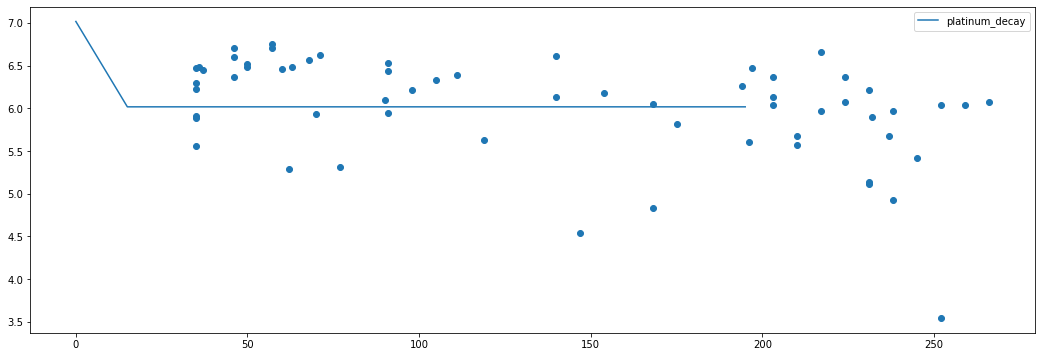

In [82]:
fig, ax = plt.subplots(figsize=(18, 6))
plt.plot(x, y0, label = 'platinum_decay')
plt.scatter(training_data['days_from_theatrical'],
           training_data[TARGET_COL])
# plt.plot(x, y2, label = 'gold_decay')
# plt.plot(x, y3, label = 'silver_decay')
# plt.plot(x, y4, label = 'bronze_decay')

plt.legend()
plt.show()

In [143]:
write_to_sf(scoring_data[OUTPUT_COLS], 'genre_level_first_views')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning:

Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/



# WRITE TO SF

In [5]:
import boto3
import io

In [6]:
def to_s3(filename, output_bucket, content):
    client = boto3.client('s3')
    client.put_object(Bucket=output_bucket, Key=filename, Body=content)

In [7]:
output_bucket = 'hbo-outbound-datascience-content-dev'
s3 = boto3.resource('s3')
bucket = s3.Bucket(output_bucket)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [8]:
def write_to_sf(df, file_name):
    csv_buffer = io.StringIO()
    df.to_csv(csv_buffer, index = False)
    content = csv_buffer.getvalue()
    filename = 'movie_windowing/movie_window_prediction_{}.csv'.format(file_name)
    to_s3(filename, output_bucket, content)

In [9]:
OUTPUT_COLS = ['title_id', 'imdb_id', 'title', 'home_territory_observed_medal', 'pillar_genres', 'area_gross', 'medal_number', 'budget', 'days_from_theatrical2', 'kpi', 'pred']

In [10]:
from abc import ABCMeta, abstractmethod

class Credentials(metaclass=ABCMeta):
    pass
    
    
class SSMPSCredentials(Credentials):
    def __init__(self, secretid: str):
        self._secretid = secretid
        self._secrets = {}
        
    def get_keys(self):
        """
        credential fetching 
        """
        _aws_sm_args = {'service_name': 'secretsmanager', 'region_name': 'us-east-1'}
        secrets_client = boto3.client(**_aws_sm_args)
        get_secret_value_response = secrets_client.get_secret_value(SecretId=self._secretid)
        return get_secret_value_response
    
    
class BaseConnector(metaclass=ABCMeta):
    @abstractmethod
    def connect(self):
        raise NotImplementedError
    

class SnowflakeConnector(BaseConnector):
    def __init__(self, credentials: Credentials):
        keys = credentials.get_keys()
        self._secrets = json.loads(keys.get('SecretString', "{}"))

    def connect(self, dbname: str, schema: str = 'DEFAULT'):
        ctx = snowflake.connector.connect(
            user=self._secrets['login_name'],
            password=self._secrets['login_password'],
            account=self._secrets['account'],
            warehouse=self._secrets['warehouse'],
            database=dbname,
            schema=schema
        )

        return ctx
    
## Credentials
SF_CREDS = 'datascience-max-dev-sagemaker-notebooks'

## Snowflake connection 
conn=SnowflakeConnector(SSMPSCredentials(SF_CREDS))
ctx=conn.connect("MAX_DEV","WORKSPACE")

def run_query(query):
    cursor = ctx.cursor()
    cursor.execute(query)
    df = pd.DataFrame(cursor.fetchall(), columns = [desc[0] for desc in cursor.description])
    df.columns= df.columns.str.lower()
    return df

In [154]:
run_query('''
create or replace table max_dev.workspace.movie_window_prediction_title_level_subs
(
title_id	VARCHAR,
imdb_id	VARCHAR,
title	VARCHAR,
home_territory_observed_medal	VARCHAR,
pillar_genres	VARCHAR,
area_gross	FLOAT,
medal_number	INT,
budget	FLOAT,
days_from_theatrical2	INT,
kpi	VARCHAR,
pred FLOAT
);

''')


,status
0,Table MOVIE_WINDOW_PREDICTION_TITLE_LEVEL_SUBS...


In [18]:
# run_query('''
# create or replace table max_dev.workspace.movie_window_prediction_actual_value
# (
# title_id	VARCHAR,
# days_from_theatrical2 int,
# value FLOAT,
# kpi	VARCHAR
# );

# ''')

,status
0,Table MOVIE_WINDOW_PREDICTION_ACTUAL_VALUE suc...


In [ ]:
#first_views #genre_level_first_views

In [155]:
run_query('''
copy into max_dev.workspace.movie_window_prediction_title_level_subs
    from(
        select
              $1, $2, $3, $4, $5, $6, $7, $8, $9, $10, $11
        from @HBO_OUTBOUND_DATASCIENCE_CONTENT_DEV/movie_windowing/movie_window_prediction_title_level_subs.csv
        )
    file_format = (type = csv null_if=('') skip_header = 1  FIELD_OPTIONALLY_ENCLOSED_BY='"')
    on_error = 'CONTINUE';

''')

,file,status,rows_parsed,rows_loaded,error_limit,errors_seen,first_error,first_error_line,first_error_character,first_error_column_name
0,s3://hbo-outbound-datascience-content-dev/movi...,LOADED,1022,1022,1022,0,None,None,None,None


In [19]:
# run_query('''
# copy into max_dev.workspace.movie_window_prediction_actual_value
#     from(
#         select
#               $1, $2, $3, $4
#         from @HBO_OUTBOUND_DATASCIENCE_CONTENT_DEV/movie_windowing/movie_window_prediction_actual_value.csv
#         )
#     file_format = (type = csv null_if=('') skip_header = 1  FIELD_OPTIONALLY_ENCLOSED_BY='"')
#     on_error = 'CONTINUE';

# ''')

,file,status,rows_parsed,rows_loaded,error_limit,errors_seen,first_error,first_error_line,first_error_character,first_error_column_name
0,s3://hbo-outbound-datascience-content-dev/movi...,LOADED,206,206,206,0,None,None,None,None


In [189]:
training_data.head()

,Unnamed: 0,title_id,title,home_territory_observed_medal,pillar_genres,imdb_id,theatrical_release_date,offering_start_date,days_from_theatrical2,pct_actives,days_from_max_launch,cumulative_viewing_subs,cumulative_first_views,area_gross,budget,genre_Action/Adventure,genre_Comedy,genre_Drama,genre_Horror,genre_Kids/Family,genre_Romance,genre_Sci-Fi,genre_Suspense/Thriller,medal_number,platform,medal_Bronze,medal_Gold,medal_Platinum,medal_Silver,log_cumulative_first_views
0,0,GYPXEhQg3DFbCwwEAAADm,News of the World,Silver,Action/Adventure,tt6878306,2020-12-25,2021-09-05,250,0.09,-219,2557041,25362,"2,250,430.00","38,000,000.00",1,0,0,0,0,0,0,0,2,1.00,0,0,0,1,14.63
3,3,GYbzvWABDj8LDwgEAAAAp,The Last Duel,Gold,Drama,tt4244994,2021-10-15,2022-01-14,91,0.16,-513,5012315,33314,"4,759,151.00","100,000,000.00",0,0,1,0,0,0,0,0,1,1.00,0,1,0,0,15.02
4,4,GYm0w5wSRXaTDYQEAAAD4,Last Night in Soho,Silver,Suspense/Thriller,tt9639470,2021-10-29,2022-07-01,245,0.07,-527,2005376,8975,"4,178,460.00","43,000,000.00",0,0,0,0,0,0,0,1,2,1.00,0,0,0,1,13.13
6,6,GYd9P0QTRLMLDJwEAAAAP,Antlers,Silver,Horror,tt7740510,2021-10-11,2022-02-11,123,0.09,-509,2614867,14444,"4,271,346.00",0.00,0,0,0,1,0,0,0,0,2,1.00,0,0,0,1,13.82
7,7,GYfinBwyKBImYsgEAAACn,Halloween Kills,Silver,Horror,tt10665338,2021-10-15,2022-03-18,137,0.10,-513,2838005,28030,"49,404,980.00","20,000,000.00",0,0,0,1,0,0,0,0,2,1.00,0,0,0,1,14.77


In [15]:
df1 = training_data[['title_id', 'days_from_theatrical2', 'cumulative_viewing_subs']].rename(columns = {'cumulative_viewing_subs':'value'})
df1['kpi'] = 'viewing_subs'
df2 = training_data[['title_id', 'days_from_theatrical2', 'cumulative_first_views']].rename(columns = {'cumulative_first_views':'value'})
df2['kpi'] = 'first_views'
actual_data = pd.concat([df1, df2], axis = 0)

In [16]:
write_to_sf(actual_data, 'actual_value')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [1]:
actual_data.tail()

NameError: name 'actual_data' is not defined